In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import os
import pydicom
from glob import glob
from tqdm.notebook import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import warnings
warnings.filterwarnings("ignore")

In [3]:
dataset_dir = "../input/vinbigdata-chest-xray-abnormalities-detection/"

In [4]:
train_csv = pd.read_csv(dataset_dir+'train.csv')
train_csv.head(10)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0
8,d3637a1935a905b3c326af31389cb846,Aortic enlargement,0,R10,1329.0,743.0,1521.0,958.0
9,afb6230703512afc370f236e8fe98806,Pulmonary fibrosis,13,R9,1857.0,1607.0,2126.0,2036.0


In [5]:
train_csv[train_csv.image_id == '9a5094b2563a1ef3ff50dc5c7ff71345']

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
5517,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,10,R9,1789.0,1729.0,1875.0,1992.0
25023,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,11,R9,1789.0,1729.0,1875.0,1992.0
26165,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R9,692.0,1375.0,1657.0,1799.0
42709,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R8,689.0,1313.0,1666.0,1763.0
53473,9a5094b2563a1ef3ff50dc5c7ff71345,Aortic enlargement,0,R9,1052.0,715.0,1299.0,966.0


In [6]:
print(train_csv.shape)
print(np.unique(train_csv.image_id).shape)

(67914, 8)
(15000,)


In [7]:
print(len(os.listdir("../input/vinbigdata-chest-xray-abnormalities-detection/train")))

15000


Converting DICOM images into Numpy array and ploting them

In [8]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    
    # not sure why this is done? 
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

def plot_img(img_path, size = (7,7), cmap = 'gray'):
    img = read_xray(img_path)
    plt.figure(figsize=size)
    plt.imshow(img, cmap = cmap)
    plt.show()

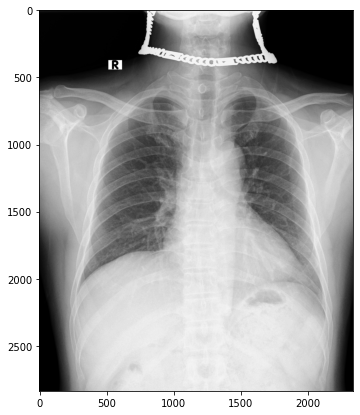

In [9]:
plot_img('../input/vinbigdata-chest-xray-abnormalities-detection/train/000434271f63a053c4128a0ba6352c7f.dicom')

In [10]:
# W = []
# H = []
# for i in tqdm(os.listdir('../input/vinbigdata-chest-xray-abnormalities-detection/train')):
#     data = pydicom.read_file(dataset_dir+'train/'+i)
#     w, h = data.Rows, data.Columns
#     W.append(w)
#     H.append(h)
#     plt.plot(W)
#     plt.plot(H)

### Looking into CSV file

In [11]:
np.unique(train_csv.class_name)

array(['Aortic enlargement', 'Atelectasis', 'Calcification',
       'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration',
       'Lung Opacity', 'No finding', 'Nodule/Mass', 'Other lesion',
       'Pleural effusion', 'Pleural thickening', 'Pneumothorax',
       'Pulmonary fibrosis'], dtype=object)

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64


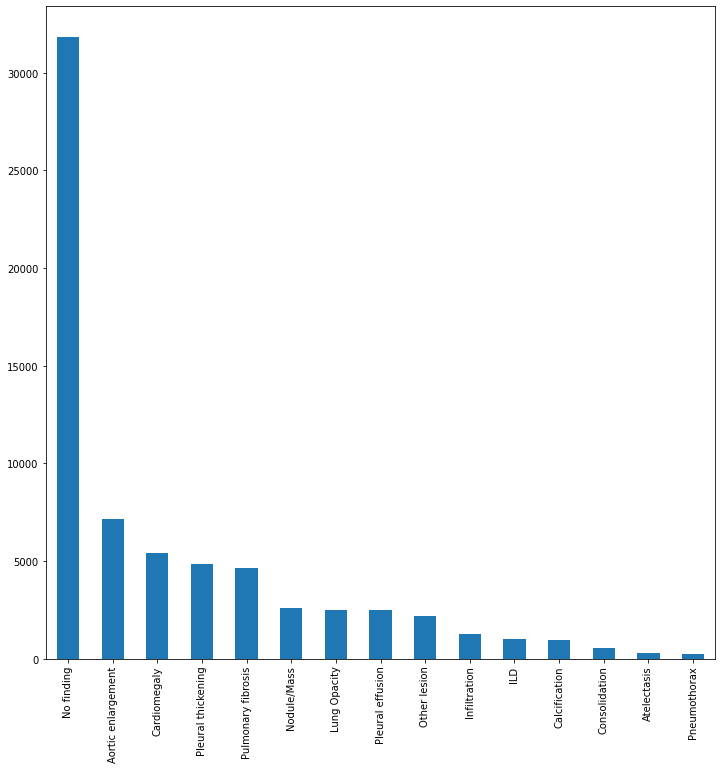

In [12]:
plt.figure(figsize = (12,12))
train_csv['class_name'].value_counts().plot.bar()
print(train_csv['class_name'].value_counts())

In [13]:
(train_csv['class_name'].value_counts())

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64

In [16]:
A = {}
for i in np.unique(train_csv.class_name):
    A[i] = np.unique(train_csv[train_csv['class_name'] == i].image_id).shape[0]
#     print(f"{i}:{np.unique(train_csv[train_csv['class_name'] == i].image_id).shape[0]}")

In [17]:
unique_xrays_count = pd.Series(A)
unique_xrays_count.sort_values(ascending=False)

No finding            10606
Aortic enlargement     3067
Cardiomegaly           2300
Pleural thickening     1981
Pulmonary fibrosis     1617
Lung Opacity           1322
Other lesion           1134
Pleural effusion       1032
Nodule/Mass             826
Infiltration            613
Calcification           452
ILD                     386
Consolidation           353
Atelectasis             186
Pneumothorax             96
dtype: int64

In [18]:
count_df= pd.DataFrame(dict(s1 = (train_csv['class_name'].value_counts()), s2 = unique_xrays_count)).reset_index()
count_df

,index,s1,s2
0,Aortic enlargement,7162,3067
1,Atelectasis,279,186
2,Calcification,960,452
3,Cardiomegaly,5427,2300
4,Consolidation,556,353
5,ILD,1000,386
6,Infiltration,1247,613
7,Lung Opacity,2483,1322
8,No finding,31818,10606
9,Nodule/Mass,2580,826


<AxesSubplot:>

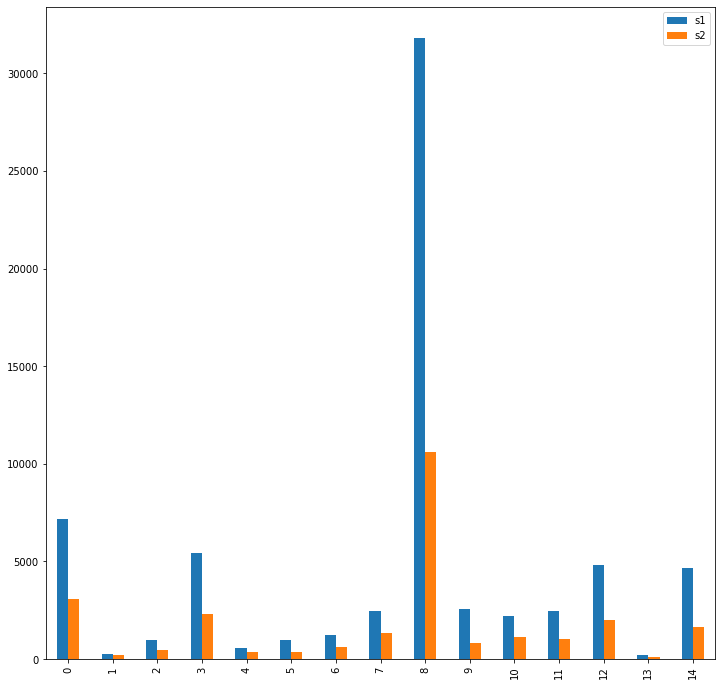

In [19]:
count_df.plot.bar(figsize = (12,12))

In [20]:
whatassigned = train_csv[['rad_id', 'class_id', 'image_id']].groupby(['rad_id', 'class_id']).count().reset_index().pivot(index = 'rad_id', columns = 'class_id', values = 'image_id').add_prefix('class').fillna(0).astype(np.int64)
whatassigned['percentage no finding'] = 0
whatassigned['percentage no finding'] = (whatassigned.iloc[:,14].values/np.sum(whatassigned, axis = 1).values)*100


In [21]:
whatassigned

class_id,class0,class1,class2,class3,class4,class5,class6,class7,class8,class9,class10,class11,class12,class13,class14,percentage no finding
rad_id,,,,,,,,,,,,,,,,
R1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1995,100.000000
R10,2349,115,139,1835,91,218,338,929,866,650,790,1186,74,1391,2321,17.461631
R11,30,6,46,41,7,10,0,12,16,15,14,19,1,40,1413,84.610778
R12,12,8,11,28,2,9,9,4,12,19,12,10,1,12,1580,91.382302
R13,32,10,39,20,9,49,22,39,18,22,8,15,1,35,1505,82.510965
R14,74,13,25,27,1,38,14,21,27,37,11,24,2,10,1300,80.049261
R15,25,8,43,29,9,37,9,14,17,52,15,22,0,35,1508,82.720790
R16,23,2,30,11,8,34,3,8,17,18,18,4,2,20,1565,88.769144
R17,10,2,7,3,0,9,1,3,5,5,3,7,0,14,743,91.502463


In [22]:
train_csv[train_csv['image_id']=='000434271f63a053c4128a0ba6352c7f']

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
689,000434271f63a053c4128a0ba6352c7f,No finding,14,R6,NaN,NaN,NaN,NaN
56742,000434271f63a053c4128a0ba6352c7f,No finding,14,R2,NaN,NaN,NaN,NaN
65515,000434271f63a053c4128a0ba6352c7f,No finding,14,R3,NaN,NaN,NaN,NaN


In [23]:
train_csv[train_csv['image_id']=='03e6ecfa6f6fb33dfeac6ca4f9b459c9']

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
757,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R9,562.0,2045.0,629.0,2112.0
1906,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R10,2046.0,778.0,2308.0,1111.0
2087,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R10,1766.0,634.0,2645.0,2567.0
2489,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R8,2239.0,1592.0,2336.0,1690.0
2610,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R8,515.0,1732.0,589.0,1799.0
3318,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R8,2030.0,792.0,2358.0,1237.0
5824,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R9,628.0,1186.0,696.0,1247.0
6628,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R8,2018.0,1302.0,2088.0,1372.0
9194,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R9,1775.0,750.0,1852.0,831.0
12042,03e6ecfa6f6fb33dfeac6ca4f9b459c9,Nodule/Mass,8,R8,424.0,1349.0,493.0,1418.0


In [24]:
import os
import re
import pandas as pd
from fastai.medical.imaging import *
from fastai.vision.all import *
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
from tqdm.auto import tqdm # for getting a progress bar on loops
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


/opt/conda/lib/python3.7/site-packages/kornia/augmentation/augmentation.py:1875: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  category=DeprecationWarning,


In [25]:
train_csv[train_csv['image_id']=='9a5094b2563a1ef3ff50dc5c7ff71345']

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
5517,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,10,R9,1789.0,1729.0,1875.0,1992.0
25023,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,11,R9,1789.0,1729.0,1875.0,1992.0
26165,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R9,692.0,1375.0,1657.0,1799.0
42709,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R8,689.0,1313.0,1666.0,1763.0
53473,9a5094b2563a1ef3ff50dc5c7ff71345,Aortic enlargement,0,R9,1052.0,715.0,1299.0,966.0


In [26]:
TEST_DCM = Path("../input/vinbigdata-chest-xray-abnormalities-detection/train/9a5094b2563a1ef3ff50dc5c7ff71345.dicom")
dcm = TEST_DCM.dcmread()

In [27]:
dcm

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 158
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 9a5094b2563a1ef3ff50dc5c7ff71345
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's Age                       AS: '061Y'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME1'
(0028, 0010) Rows                                US: 2336
(0028, 0011) Columns                             US: 2080
(0028, 0100) Bits Al

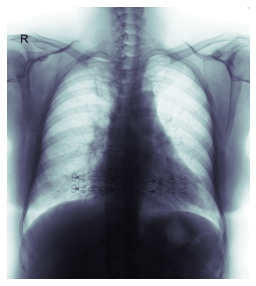

In [28]:
dcm.show()

<Figure size 1440x1440 with 0 Axes>

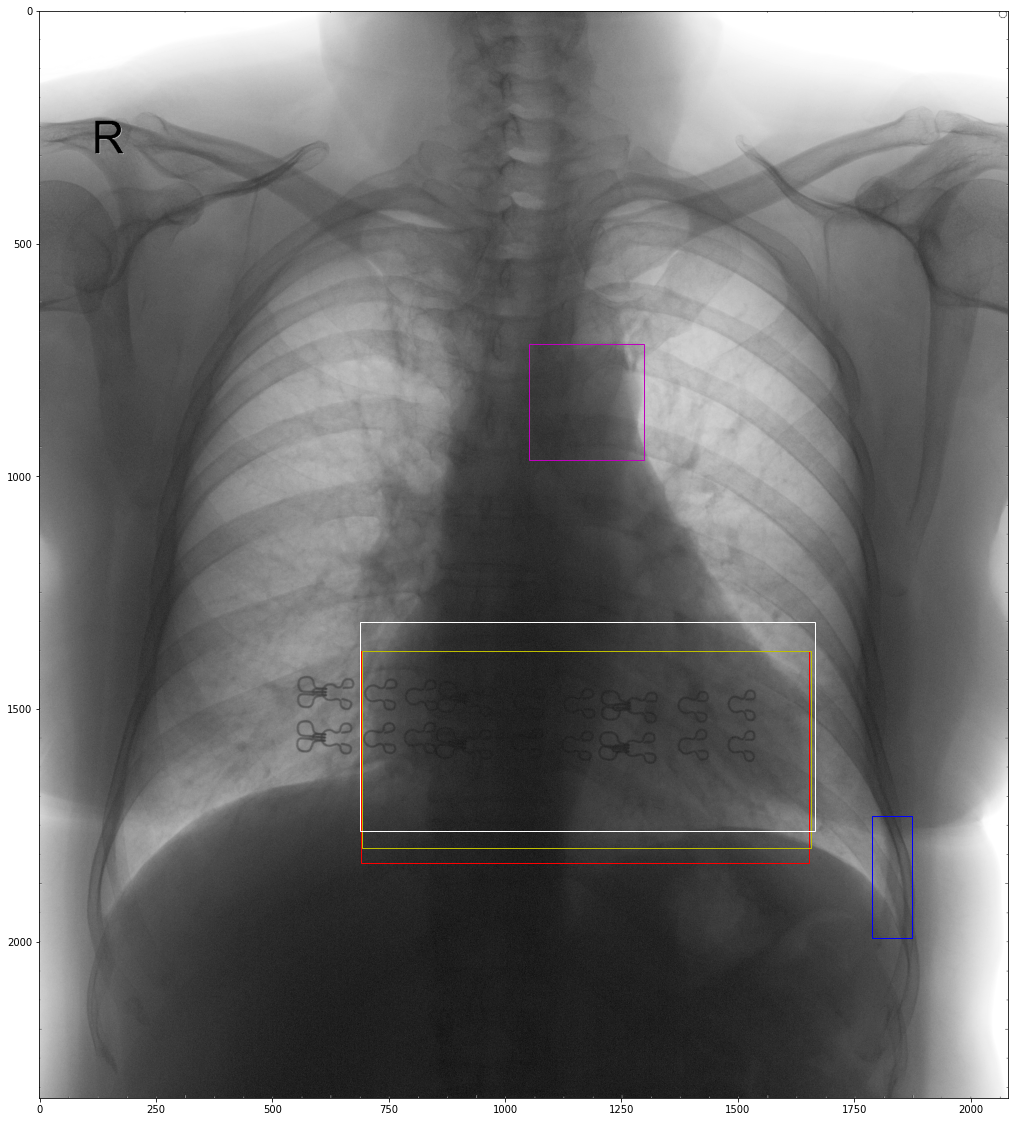

In [27]:
plt.figure(figsize = (20,20))
fig, ax = plt.subplots(1, figsize = (20,20))
color = ['r', 'g', 'b', 'y', 'w', 'm']
ax.imshow(dcm.pixels, cmap = 'gray')
for i in range(0,len(train_csv[train_csv['image_id']=='9a5094b2563a1ef3ff50dc5c7ff71345'])):
    rect = ptc.Rectangle((train_csv[train_csv['image_id']=='9a5094b2563a1ef3ff50dc5c7ff71345'].reset_index(drop = True).x_min[i], train_csv[train_csv['image_id']=='9a5094b2563a1ef3ff50dc5c7ff71345'].reset_index(drop = True).y_min[i]), train_csv[train_csv['image_id']=='9a5094b2563a1ef3ff50dc5c7ff71345'].reset_index(drop = True).x_max[i]-train_csv[train_csv['image_id']=='9a5094b2563a1ef3ff50dc5c7ff71345'].reset_index(drop = True).x_min[i], 
                         train_csv[train_csv['image_id']=='9a5094b2563a1ef3ff50dc5c7ff71345'].reset_index(drop = True).y_max[i]-train_csv[train_csv['image_id']=='9a5094b2563a1ef3ff50dc5c7ff71345'].reset_index(drop = True).y_min[i], 
                         linewidth = 1, edgecolor = color[i], facecolor = 'none')
    ax.add_patch(rect)
plt.show()

In [28]:
locations = np.zeros((14, int(np.ceil(np.max(train_csv.y_max)/10)*10), int(np.ceil(np.max(train_csv.x_max)/10)*10)))
for index, row in tqdm(train_csv.iterrows(), total=train_csv.shape[0]):
    if row['class_id']<14:
        locations[row['class_id'], int(row['y_min']):int(row['y_max']+1), int(row['x_min']):int(row['x_max']+1)] += 1


100%|██████████| 67914/67914 [00:32<00:00, 2078.69it/s]


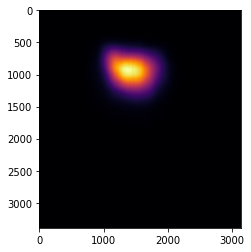

In [29]:
plt.imshow(locations[0], cmap = 'inferno')

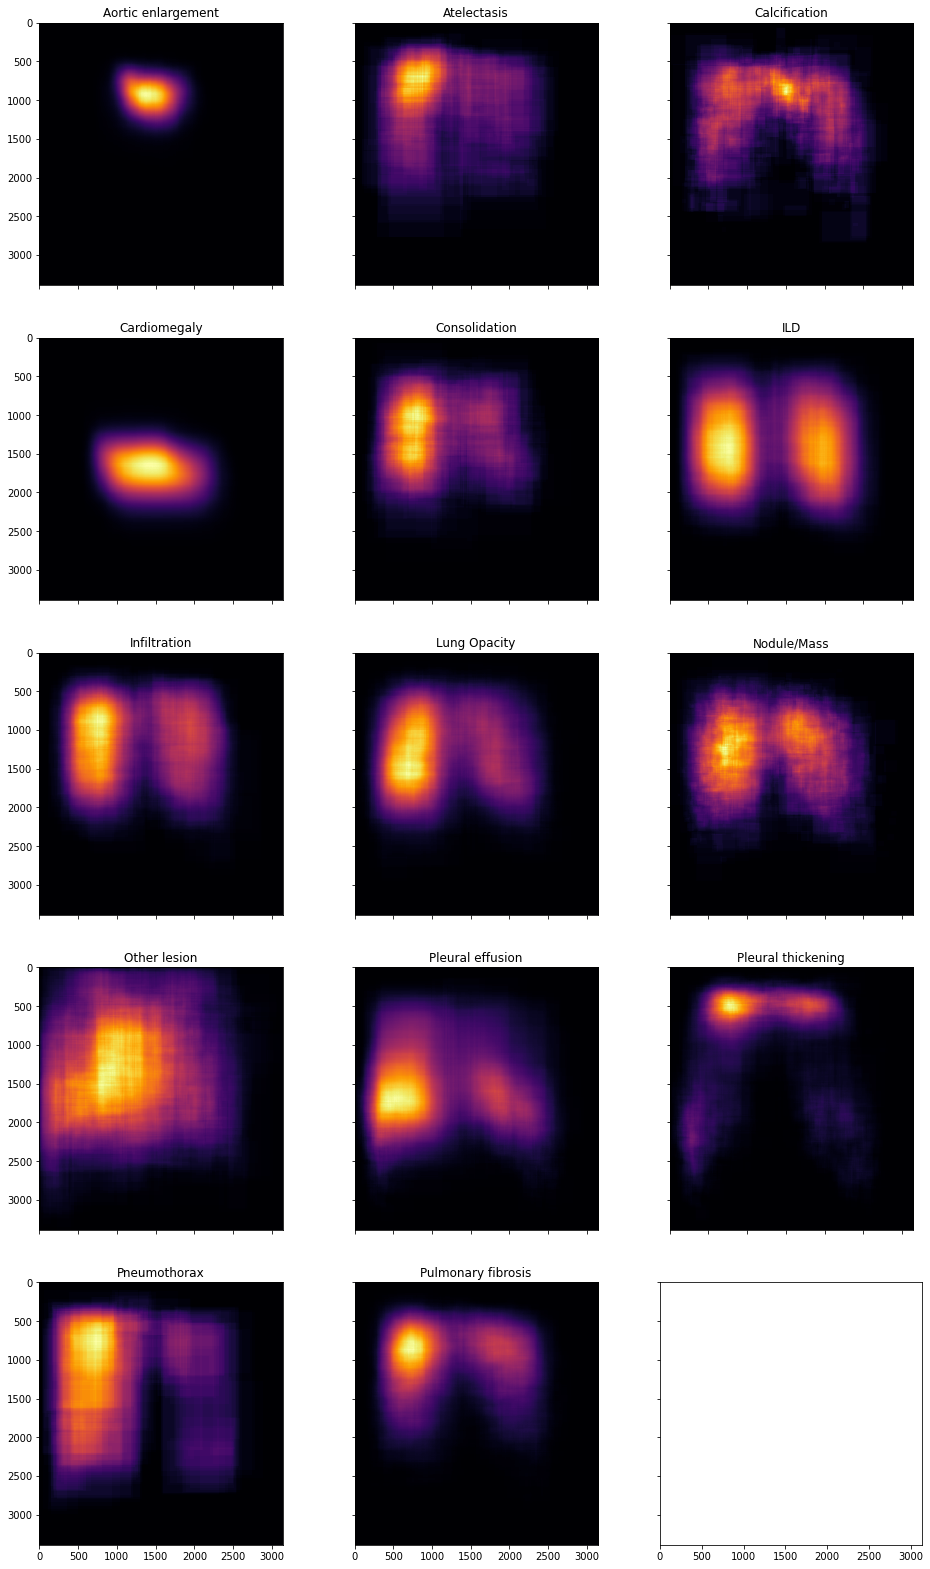

In [30]:
f, axs = plt.subplots(5, 3, sharey=True, sharex=True, figsize=(16,28));
for i, (index,row) in enumerate((train_csv[['class_name', 'class_id']].groupby(['class_name', 'class_id']).count().drop('No finding').iterrows())):
    a,b = index
    axs[b//3, b-(3*(b//3))].imshow(locations[b], cmap = 'inferno', interpolation='nearest')
    axs[b//3, b-(3*(b//3))].set_title(a)
    

In [41]:
cols = ['#e41a1c', '#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999', '#000000', '#1b9e77', '#d95f02', '#7570b3', '#e7298a']

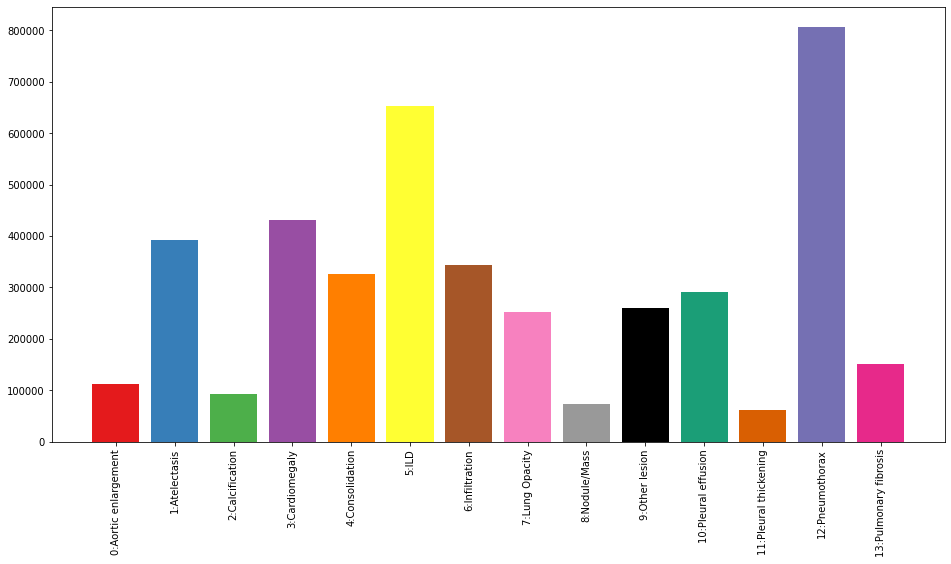

In [83]:
train_csv['size'] = (train_csv['x_max']-train_csv['x_min'])*(train_csv['y_max']-train_csv['y_min'])
sizes = train_csv.loc[train_csv['class_id']<14, ['class_id', 'size']].groupby('class_id').mean().reset_index()

plt.figure(figsize = (16,8))
plt.bar(sizes['class_id'], sizes['size'],
       tick_label = [str(i[0][1])+ ':'+ i[0][0] for i in (train_csv[['class_name', 'class_id']].groupby(['class_name','class_id']).count().drop('No finding').iterrows())],
       color = cols)

plt.xticks(rotation='vertical');

In [162]:
#Dicom Meta Data
train_path = '../input/vinbigdata-chest-xray-abnormalities-detection/train/'
files =  [f for f in os.listdir(train_path) if os.path.isfile(os.path.join(train_path, f))]

In [160]:
prog = re.compile('^[A-Z]*')

def get_dcm_contents(file):
    dcm = Path(train_path + file).dcmread()
    properties =  [string for string in dir(dcm) if prog.match(string).group(0) !='']
    dict1 = {'file': file.replace('dicom', '')}
    dict1.update( { what: dcm[what].value for what in properties if isinstance(dcm[what].value, (bytes, bytearray))!=True } )
    
    return dict1

In [166]:
train_files = pd.DataFrame([get_dcm_contents(file) for file in tqdm(files)])

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 17/15000 [01:16<18:50:58,  4.53s/it]


In [167]:
train_files['Aspect Ratio'] = train_files['Columns'] / train_files['Rows']
np.mean(train_files['Aspect Ratio'])

0.8771590849205955

In [168]:
train_files.to_csv('train_dicom_properties.csv.bz2', compression='bz2', index=False)


In [169]:
train_files.to_csv("train_dicom_properties.csv", index = False)

In [170]:
train_files

,file,BitsAllocated,BitsStored,Columns,HighBit,LossyImageCompression,PatientSex,PatientSize,PatientWeight,PhotometricInterpretation,...,WindowCenter,WindowWidth,LossyImageCompressionMethod,LossyImageCompressionRatio,NumberOfFrames,PatientAge,PixelSpacing,LargestImagePixelValue,SmallestImagePixelValue,Aspect Ratio
0,4d390e07733ba06e5ff07412f09c0a92.,16,12,3000,11,00,O,0.0,0.0,MONOCHROME2,...,2047.0,4095.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
1,289f69f6462af4933308c275d07060f0.,16,14,3072,13,,F,NaN,NaN,MONOCHROME2,...,8897.0,11412.0,,NaN,1.0,046Y,"[0.140, 0.140]",NaN,NaN,1.000000
2,68335ee73e67706aa59b8b55b54b11a4.,16,12,2336,11,00,O,NaN,NaN,MONOCHROME1,...,2047.0,4095.0,NaN,NaN,NaN,NaN,"[0.15, 0.15]",NaN,NaN,0.823695
3,7ecd6f67f649f26c05805c8359f9e528.,16,14,2744,13,00,M,NaN,NaN,MONOCHROME2,...,8190.0,7259.0,NaN,2.0,NaN,061Y,"[0.127, 0.127]",NaN,NaN,0.929539
4,2229148faa205e881cf0d932755c9e40.,16,12,2304,11,00,M,NaN,NaN,MONOCHROME1,...,2047.0,4095.0,NaN,NaN,NaN,NaN,"[0.15, 0.15]",NaN,NaN,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,b3510302f95f75a91e0fd49e04767f02.,16,14,3072,13,,M,NaN,NaN,MONOCHROME2,...,8653.0,11884.0,,NaN,1.0,055Y,"[0.140, 0.140]",NaN,NaN,1.000000
14996,dcb081bb5e1dac41000e96fc37c8c322.,16,16,2507,15,00,F,NaN,NaN,MONOCHROME2,...,32767.0,65535.0,NaN,NaN,1.0,000Y,"[0.141, 0.141]",NaN,NaN,0.945681
14997,c619a784636c085eb798f98a5ba1102d.,16,12,2641,11,00,M,NaN,NaN,MONOCHROME2,...,2124.0,3435.0,NaN,NaN,NaN,064Y,NaN,NaN,NaN,0.918609
14998,e7ea94b2fec95a7461b10a7f3eea2897.,16,14,3072,13,,F,NaN,NaN,MONOCHROME2,...,8035.0,9144.0,,NaN,1.0,080Y,"[0.140, 0.140]",NaN,NaN,1.000000


In [29]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train_files, title="Pandas Profiling Report")
profile.to_widgets()


In [48]:
train_csv

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0


In [46]:
def view_with_annot(image_name):
    img = read_xray(f"../input/vinbigdata-chest-xray-abnormalities-detection/train/{image_name}.dicom")
    fig, ax = plt.subplots(1, figsize = (10,10))
    ax.imshow(img, cmap = 'gray')

    for i in range(0,len(train_csv[train_csv['image_id']==image_name])):
        rect = ptc.Rectangle((train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_min[i], 
                              train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_min[i]), 
                             train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_max[i]-train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_min[i], 
                             train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_max[i]-train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_min[i], 
                             linewidth = 1, edgecolor = cols[i], facecolor = 'none')
        ax.add_patch(rect)
        ax.annotate(train_csv[train_csv['image_id']==image_name].reset_index(drop = True).class_name[i],
                    (train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_min[i], 
                    train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_min[i] - 24) )

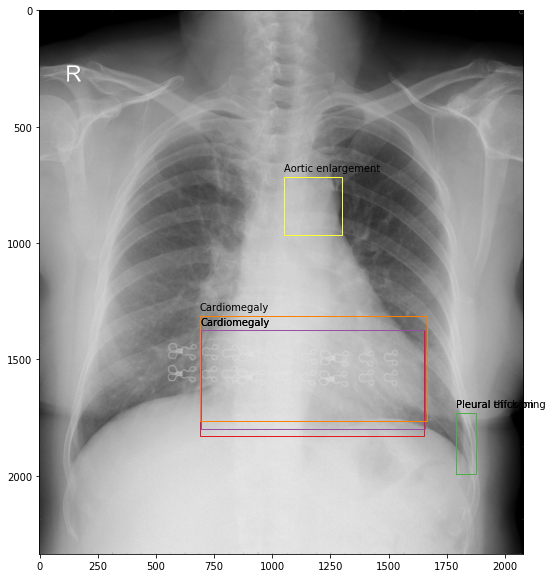

In [47]:
view_with_annot('9a5094b2563a1ef3ff50dc5c7ff71345')

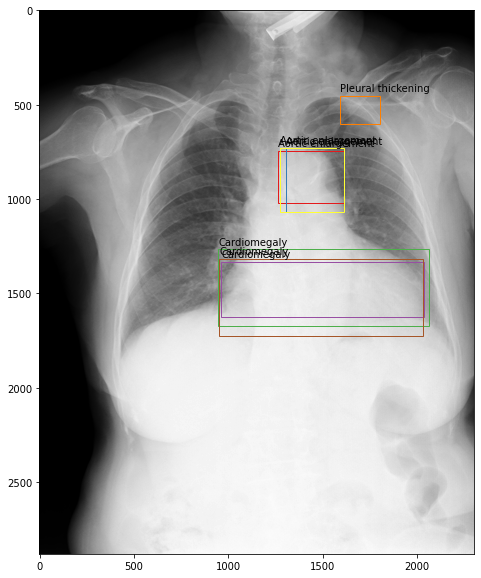

In [49]:
view_with_annot('051132a778e61a86eb147c7c6f564dfe')